---
This notebook preprocesses the raw card images and applies several transformations.

First we'll crop the images and save them in `processed-images/`.

---

In [1]:
import os
from PIL import Image

card_width = 352
card_height = 550
input_directory = 'card-images'
output_directory = 'cropped-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in os.listdir(input_directory):
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  cropped_image = image.crop((0, 0, card_width, card_height))
  output_path = os.path.join(output_directory, filename)
  cropped_image.save(output_path)

---
Now we'll apply several random rotations to each image.

---

In [5]:
import random


input_directory = 'cropped-images'
output_directory = 'rotated-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

# Our rotations are randomly selected to be +/- 30deg.
number_of_rotations = 20
rotation_range = range(0, 30)
rotation_range.extend(range(330, 359))
random.seed(2)
# Capture the output dimensions of the largest images --
# we'll later make all images this size.
largest_width, largest_height = 0, 0
for filename in os.listdir(input_directory):
  params = {
    'number': filename.split('-')[0],
    'color': filename.split('-')[1],
    'texture': filename.split('-')[2],
    'shape': filename.split('-')[3].split('.')[0],
  }
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  rotations_to_apply = random.sample(rotation_range, number_of_rotations)
  for rotation in rotations_to_apply:
    params['rotation'] = rotation
    rotated_image = image.rotate(rotation, expand=True, resample=Image.BICUBIC)
    new_filename = '%s-%s-%s-%s-%s.png' % (
      params['number'], params['color'], params['texture'], params['shape'], rotation)
    output_path = os.path.join(output_directory, new_filename)
    rotated_image.save(output_path)
    if rotated_image.width > largest_width:
      largest_width = rotated_image.width
    if rotated_image.height > largest_height:
      largest_height = rotated_image.height

---
Make sure each image is the same size.

---

In [6]:
input_directory = 'rotated-images'
output_directory = 'equally-sized-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)
  
for filename in os.listdir(input_directory):
  input_path = os.path.join(input_directory, filename)
  output_path = os.path.join(output_directory, filename)
  image = Image.open(input_path)
  if image.width < largest_width or image.height < largest_height:
    new_image = Image.new('RGB', (largest_width, largest_height), (0, 0, 0))
    left_padding = (largest_width - image.width) / 2
    top_padding = (largest_height - image.height) / 2
    new_image.paste(image, (left_padding, top_padding))
    new_image.save(output_path)
  else:
    image.save(output_path)

---
Let's display a few..

---

1-purple-striped-oval-8.png, size: (580, 654)


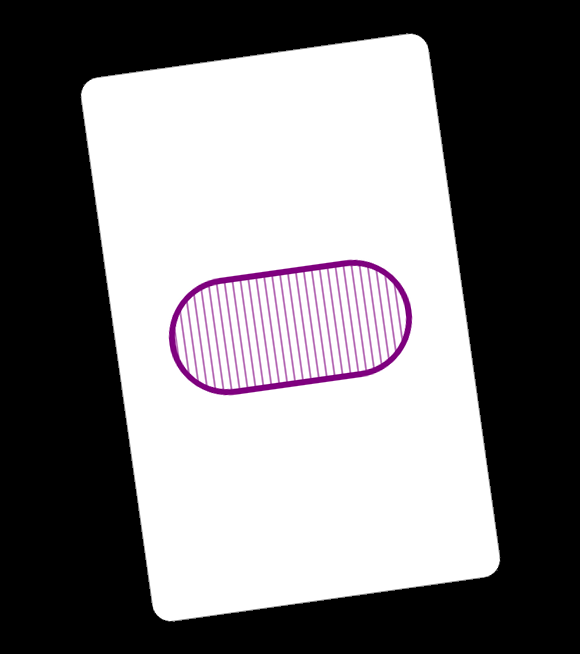

3-purple-solid-diamond-353.png, size: (580, 654)


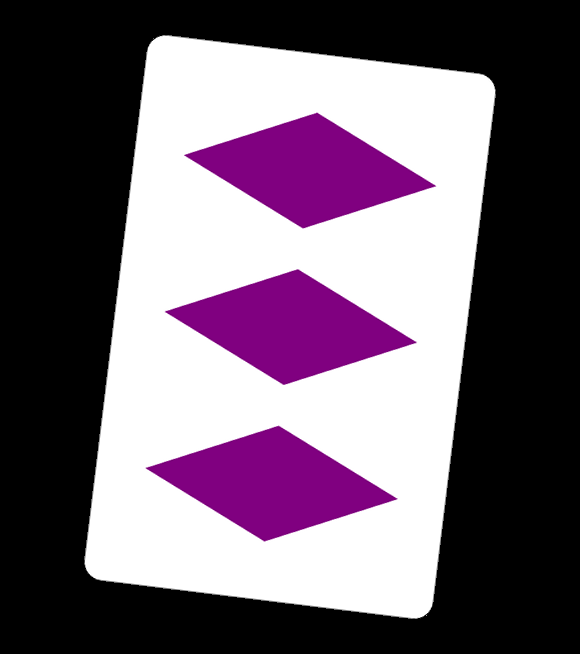

1-green-empty-oval-29.png, size: (580, 654)


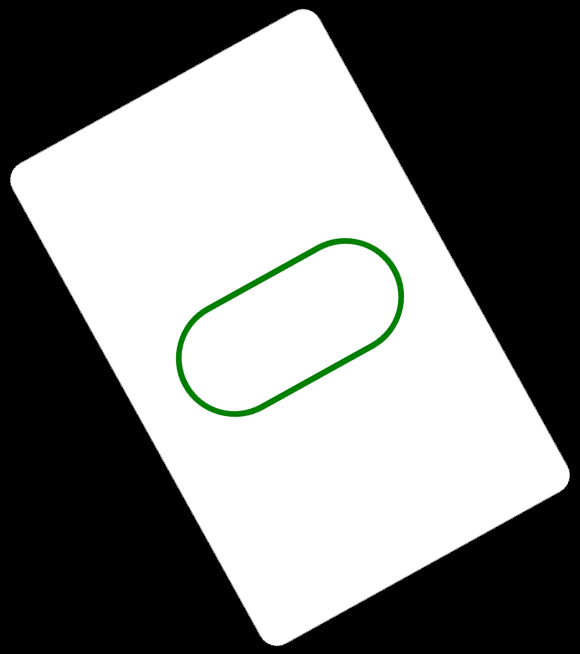

In [7]:
from IPython import display


images = random.sample(os.listdir(output_directory), 3)
for filename in images:
  path = os.path.join(output_directory, filename)
  print '%s, size: %s' % (filename, Image.open(path).size)
  display.display(display.Image(filename=path))

---
These images are 638 x 638..kinda large -- let's shrink them.

---

In [8]:
input_directory = 'equally-sized-images'
output_directory = 'resized-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)
  
width, height = 150, 150

for filename in os.listdir(input_directory):
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  resized_image = image.resize((width, height), resample=Image.ANTIALIAS)
  output_path = os.path.join(output_directory, filename)
  resized_image.save(output_path)

---
And now let's see what our images look like..

---

1-purple-striped-oval-8.png, size: (150, 150)


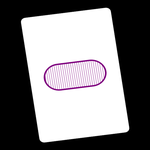

3-purple-solid-diamond-353.png, size: (150, 150)


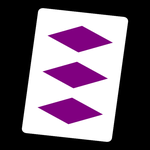

1-green-empty-oval-29.png, size: (150, 150)


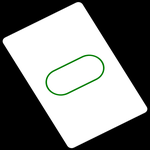

In [9]:
for filename in images:
  path = os.path.join(output_directory, filename)
  print '%s, size: %s' % (filename, Image.open(path).size)
  display.display(display.Image(filename=path))

---
Let's also create a greyscaled versions of these images -- some classifiers will use RGB images, others don't need the color data.

---

In [10]:
input_directory = 'resized-images'
output_directory = 'greyscaled-images'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in os.listdir(input_directory):
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  greyscaled_image = image.convert('L')
  output_path = os.path.join(output_directory, filename)
  greyscaled_image.save(output_path)

---
And let's view them..

---

1-purple-striped-oval-8.png


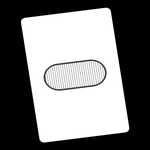

3-purple-solid-diamond-353.png


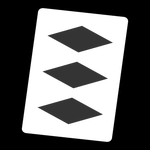

1-green-empty-oval-29.png


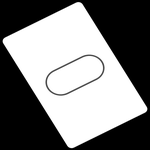

In [11]:
for filename in images:
  path = os.path.join(output_directory, filename)
  print filename
  display.display(display.Image(filename=path))

---
Finally let's convert the RGB and greyscale images into .npy data files.

RGB data first:

---

In [12]:
import numpy as np


input_directory = 'resized-images'
output_directory = 'rgb-data'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in os.listdir(input_directory):
  input_path = os.path.join(input_directory, filename)
  image = Image.open(input_path)
  number_of_channels = np.array(image).shape[2]
  pixel_data = [pixel for row in np.array(image) for pixel in row]
  # Some images have an alpha channel, some do not.
  if number_of_channels == 4:
    rgb_data = np.array([(r, g, b) for r, g, b, _ in pixel_data]).flatten()
  elif number_of_channels == 3:
    rgb_data = np.array(pixel_data).flatten()

  output_filename = '%s.npy' % filename.split('.')[0]
  output_path = os.path.join(output_directory, output_filename)
  np.save(output_path, rgb_data)

---
And the greyscaled data:

---

In [13]:
input_directory = 'greyscaled-images'
output_directory = 'greyscaled-data'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in os.listdir(input_directory):
  path = os.path.join(input_directory, filename)
  image = Image.open(path)
  pixel_data = [pixel / 255. for row in np.array(image) for pixel in row]
  output_filename = '%s.npy' % filename.split('.')[0]
  output_path = os.path.join(output_directory, output_filename)
  np.save(output_path, pixel_data)